# Bài tập lớn: Chấm điểm tín dụng với phương pháp ensemble learning

Mục tiêu: Cài đặt mô hình đánh giá tín dụng Lasso Logistic Regression Ensemble cho tập dữ liệu Kaggle, so sánh với các phương pháp học máy cơ bản như cây quyết định, rừng ngẫu nhiên và hồi quy logistic.


In [0]:
from google.colab import drive
drive.mount("/content/drive")
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Study/BML_Project/Project")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Phần 1: Thử nghiệm các phương pháp học máy trên cho tập dữ liệu Kaggle 
Tập dữ liệu này đã được tiền xử lý một cách tốt nhất (theo bài báo Wang et al, 2016), các phương pháp tiền xử lý đã được giới thiệu trong bài giảng

In [0]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from transform_data import transform_data

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

In [0]:
import pandas as pd
import numpy as np
kaggle_data = pd.read_csv("./data/cs-training.csv")
kaggle_data.drop(['Unnamed: 0'], axis=1, inplace=True)
process_data = transform_data(kaggle_data)
process_data.head()

,SeriousDlqin2yrs,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,Log.Debt,RevolvingLines,HasRevolvingLines,HasRealEstateLoans,HasMultipleRealEstateLoans,EligibleSS,DTIOver33,DTIOver43,DisposableIncome,RevolvingToRealEstate,NumberOfTime30-59DaysPastDueNotWorseLarge,NumberOfTime30-59DaysPastDueNotWorse96,NumberOfTime30-59DaysPastDueNotWorse98,Never30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorseLarge,NumberOfTime60-89DaysPastDueNotWorse96,NumberOfTime60-89DaysPastDueNotWorse98,Never60-89DaysPastDueNotWorse,NumberOfTimes90DaysLateLarge,NumberOfTimes90DaysLate96,NumberOfTimes90DaysLate98,Never90DaysLate,IncomeDivBy10,IncomeDivBy100,IncomeDivBy1000,IncomeDivBy5000,Weird0999Utilization,FullUtilization,ExcessUtilization,NumberOfTime30-89DaysPastDueNotWorse,Never30-89DaysPastDueNotWorse,NeverPastDue,Log.RevolvingUtilizationTimesLines,Log.RevolvingUtilizationOfUnsecuredLines,DelinquenciesPerLine,MajorDelinquenciesPerLine,MinorDelinquenciesPerLine,DelinquenciesPerRevolvingLine,MajorDelinquenciesPerRevolvingLine,MinorDelinquenciesPerRevolvingLine,Log.DebtPerLine,Log.DebtPerRealEstateLine,Log.DebtPerPerson,RevolvingLinesPerPerson,RealEstateLoansPerPerson,YearsOfAgePerDependent,Log.MonthlyIncome,Log.IncomePerPerson,Log.IncomeAge,Log.NumberOfTimesPastDue,Log.NumberOfTimes90DaysLate,Log.NumberOfTime30-59DaysPastDueNotWorse,Log.NumberOfTime60-89DaysPastDueNotWorse,Log.Ratio90to30-59DaysLate,Log.Ratio90to60-89DaysLate,AnyOpenCreditLinesOrLoans,Log.NumberOfOpenCreditLinesAndLoans,Log.NumberOfOpenCreditLinesAndLoansPerPerson,Has.Dependents,Log.HouseholdSize,Log.DebtRatio,Log.DebtPerDelinquency,Log.DebtPer90DaysLate,Log.UnknownIncomeDebtRatio,Log.UnknownIncomeDebtRatioPerPerson,Log.UnknownIncomeDebtRatioPerLine,Log.UnknownIncomeDebtRatioPerRealEstateLine,Log.UnknownIncomeDebtRatioPerDelinquency,Log.UnknownIncomeDebtRatioPer90DaysLate,Log.NumberRealEstateLoansOrLines,LowAge,Log.age
0,1,0,0,0,0,0,0,0.0,0,8.898802,7,1,1,1,0,1,1,1796.802984,1.0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,2,0,0,1.850482,-0.266408,0.153846,0.0,0.153846,0.285714,0.0,0.285714,6.259745,6.952892,7.800190,2.333333,2.0,15.0,9.118225,8.019613,5.289584,0.693147,0.0,0.693147,0.0,-0.693147,0.0,1,2.564949,1.466337,1,1.098612,-0.219423,7.800190,8.898802,0.0,-1.098612,-2.639057,-1.945910,-1.098612,0.000000,1.791759,0,3.332205
1,0,0,0,0,0,0,0,0.0,0,5.758517,4,1,0,0,0,0,0,2283.121877,4.0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1.574557,-0.043794,0.000000,0.0,0.000000,0.000000,0.0,0.000000,4.149079,5.758517,5.065370,2.000000,0.0,20.0,7.863267,7.170120,4.149695,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.386294,0.693147,1,0.693147,-2.104749,5.758517,5.758517,0.0,-0.693147,-1.609438,0.000000,0.000000,0.000000,0.000000,0,3.135494
2,0,0,0,1,0,0,0,0.0,0,5.556499,2,1,0,0,0,0,0,2783.085113,2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.839997,-0.418277,1.000000,0.5,0.500000,1.000000,0.5,0.500000,4.457887,5.556499,5.556499,2.000000,0.0,38.0,8.020270,8.020270,4.356709,0.693147,0.0,0.000000,0.0,0.000000,0.0,1,0.693147,0.693147,0,0.000000,-2.463771,4.457887,4.863352,0.0,0.000000,-1.098612,0.000000,-1.098612,-0.693147,0.000000,0,3.044522
3,0,0,0,1,0,0,0,0.0,0,4.778821,5,1,0,0,0,0,0,3181.036049,5.0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0.774289,-1.453247,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.987061,4.778821,4.778821,5.000000,0.0,30.0,8.101678,8.101678,4.667691,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.609438,1.609438,0,0.000000,-3.322857,4.778821,4.778821,0.0,0.000000,-1.791759,0.000000,0.000000,0.000000,0.000000,0,2.564949
4,0,0,0,1,0,0,0,0.0,0,7.368324,6,1,1,0,0,0,0,62003.024906,3.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.863062,-0.097349,0.142857,0.0,0.142857,0.166667,0.0,0.166667,5.288882,6.675177,7.368324,6.000000,1.0,49.0,11.060180,11.060180,7.148157,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.945910,1.945910,0,0.000000,-3.691856,6.675177,7.368324,0.0

In [0]:
import time
#visualization of the dataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [0]:
#Use parallel coordinates
from pandas.plotting import parallel_coordinates

In [0]:
#Số thuộc tính trên mỗi bản ghi
len(process_data.columns)

81

In [0]:
#Cái này là nhãn
kaggle_data.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

### Phần 1: Áp dụng thuật toán cây ra quyết định và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu đã xử lý thành dữ liệu huấn luyện và kiểm tra, áp dụng thuật toán cây quyết định, đánh giá 
hiệu năng (tính auc) của thuật toán, tính độ quan trọng của các thuộc tính

In [0]:
#### YOUR CODE HERE ####
# Chia dữ liệu
from sklearn.model_selection import train_test_split
x = process_data.loc[:, process_data.columns != 'SeriousDlqin2yrs']
y = process_data.SeriousDlqin2yrs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)

#### END YOUR CODE #####

In [0]:
#Tiến hành phân loại
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# Import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [0]:
# a =list(np.arange(1,30))
# a.append(None)
# print(a)

In [0]:
# decision_tree = DecisionTreeClassifier()
# param = {'max_depth': a, 'criterion': ['gini', "entropy"], 'class_weight': [None, 'balanced']}
# gs =GridSearchCV(decision_tree, param_grid=param, scoring = "roc_auc", cv=5, n_jobs=-1)
# gs.fit(x_train, y_train)
# gs.best_params_

In [0]:
decision_tree = DecisionTreeClassifier(class_weight= "balanced", criterion= 'entropy', max_depth= 5)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
y_dt_pred = decision_tree.predict(x_test)
mse_dt = MSE(y_test, y_dt_pred)
standard_deviation_dt = np.sqrt(mse_dt)
standard_deviation_dt

0.5035209363406187

In [0]:
print(mse_dt)

0.25353333333333333


In [0]:
f1_score(y_test, y_dt_pred)

0.30232984773436067

In [0]:
y_train_dt_pred = decision_tree.predict(x_train)

In [0]:
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train, y_train_dt_pred)
test_auc = roc_auc_score(y_test, y_dt_pred)
print(train_auc)
print(test_auc)

0.778112008119403
0.7813113848424007


###  Áp dụng thuật toán rừng ngẫu nhiên và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán rừng ngẫu nhiên, đánh giá 
hiệu năng (tính auc) của thuật toán, tính độ quan trọng của các thuộc tính

In [0]:
#### YOUR CODE HERE ####
# a =list(np.arange(5,11))
# a.append(None)
# b= list(np.arange(100, 150))
# param = {"n_estimators": b, 'max_depth': a, 'criterion': ['gini', "entropy"], 'class_weight': [None, 'balanced']}
# random_forest = RandomForestClassifier()
# gs =GridSearchCV(random_forest, param_grid=param, scoring = "roc_auc", cv=5, n_jobs=-1)
# gs.fit(x_train, y_train)
# gs.best_params_

#### END YOUR CODE #####

In [0]:
# gs =GridSearchCV(random_forest, param_grid=param, scoring = "f1_weighted", cv=5, n_jobs=-1)
# gs.fit(x_train, y_train)
# gs.best_params_

In [0]:
random_forest = RandomForestClassifier(n_estimators = 200, max_depth = 11, criterion =  "entropy", class_weight ="balanced")
random_forest.fit(x_train,y_train)
y_rf_pred = random_forest.predict(x_test)
mse_dt = MSE(y_test, y_rf_pred)


In [0]:
mse_rf = MSE(y_test, y_rf_pred)
standard_deviation = np.sqrt(mse_dt)
print(mse_rf)

0.15566666666666668


In [0]:
y_train_rf_pred = random_forest.predict(x_train)
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train, y_train_rf_pred)
test_auc = roc_auc_score(y_test, y_rf_pred)
print(train_auc)
print(test_auc)
print(f1_score(y_test, y_rf_pred))

0.8163787043834556
0.7777545052917265
0.375835338144881


### Câu hỏi 1.3: Áp dụng thuật toán hồi quy logistic và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán hồi quy logistic, đánh giá 
hiệu năng (tính auc) của thuật toán, hiện thị hệ số của hồi quy logistic

In [0]:
# logistic_regression = LogisticRegression()
# param = {"penalty": ["l2","l1", "none"], "class_weight": [None, "balanced"], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
# gs =GridSearchCV(logistic_regression, param_grid=param, scoring = "roc_auc" cv=5, n_jobs=-1)
# gs.fit(x_train, y_train)
# gs.best_params_

In [0]:
# gs =GridSearchCV(logistic_regression, param_grid=param, scoring = "f1_weighted", cv=5, n_jobs=-1)
# gs.fit(x_train, y_train)
# gs.best_params_

In [0]:
#### YOUR CODE HERE ####
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(penalty  = "l1", class_weight = "balanced")
logistic_regression.fit(x_train,y_train)

y_train_log_pred = logistic_regression.predict(x_train)
y_log_pred = logistic_regression.predict(x_test)
mse_dt = MSE(y_test, y_log_pred)
standard_deviation_log = np.sqrt(mse_dt)
#### END YOUR CODE #####
print(standard_deviation_log)
print("Độ đo auc trên tập train là {}".format(roc_auc_score(y_train, y_train_log_pred)))
print("Độ đo auc trên tập test là {}".format(roc_auc_score(y_test, y_log_pred)))
print(f1_score(y_test, y_log_pred))

0.4268489194082609
Độ đo auc trên tập train là 0.7806861833893213
Độ đo auc trên tập test là 0.7848251701279672
0.3540534152682581


In [0]:
MSE(y_test, y_log_pred)

0.1822

# Phần 2: Cài đặt thuật toán Lasso-Logistic Regression Ensemble cho bài toán

In [0]:
train_df =  pd.merge(y_train,x_train,how = 'right',left_index = True, right_index = True)
# a.head()
train_df.shape

(135000, 81)

In [0]:
#Tách dữ lệu huấn luyện thành tập dữ liệu nợ tốt và nợ xấu, chúng ta sẽ tiến hành 
train_bad_debt = train_df[train_df.SeriousDlqin2yrs == 1]
train_good_debt = train_df[train_df.SeriousDlqin2yrs == 0]

In [0]:
k_list = []
inert_list = []
from sklearn.cluster import KMeans, MeanShift
for k in range (2, 40):
 
	# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
  kmeans_model = KMeans(n_clusters=k, random_state=1).fit(train_good_debt.loc[:, train_good_debt.columns != 'SeriousDlqin2yrs'])
	
	# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
  labels = kmeans_model.labels_
 
	# Sum of distances of samples to their closest cluster center
  inertia = kmeans_model.inertia_
  k_list.append(k)
  inert_list.append(inertia)
  print("k:",k, " cost:", inertia)
  print(pd.value_counts(labels))

k: 2  cost: 11382260364721.566
0    125975
1         2
dtype: int64
k: 3  cost: 6580215103579.388
0    125964
2        11
1         2
dtype: int64
k: 4  cost: 5099958281488.464
0    125622
3       342
2        11
1         2
dtype: int64
k: 5  cost: 3962770471085.2144
2    94460
0    31291
3      213
4       11
1        2
dtype: int64
k: 6  cost: 3224403048132.789
5    94318
0    31428
4      218
2       11
3        1
1        1
dtype: int64
k: 7  cost: 2560653637577.1304
0    95011
2    30722
6      213
5       18
3       11
4        1
1        1
dtype: int64
k: 8  cost: 2131153288407.017
2    84585
0    39941
7     1315
4      105
5       18
3       11
6        1
1        1
dtype: int64
k: 9  cost: 1770789817427.0723
0    84454
3    40055
7     1329
4      107
6       14
2       11
8        5
5        1
1        1
dtype: int64
k: 10  cost: 1442206741016.4656
0    63409
6    52129
3    10085
5      302
9       22
7       14
2        9
8        5
4        1
1        1
dtype: int64
k: 1

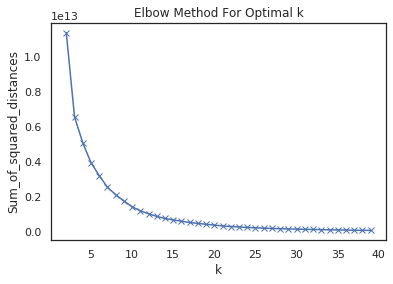

In [0]:
import matplotlib.pyplot as plt
plt.plot(k_list, inert_list, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
#Optimal k nằm trong khoảng 6, 8. Thử chọn k bằng 7 để tạo phân cụm lớp nợ tốt

In [0]:
clustering = KMeans(n_clusters= 20 , random_state=1000)
clustering.fit(train_good_debt.loc[:, train_good_debt.columns != 'SeriousDlqin2yrs'])
predict=clustering.predict(train_good_debt.loc[:, train_good_debt.columns != 'SeriousDlqin2yrs'])
train_good_debt["Cluster_label"] = predict

In [0]:
train_good_debt.Cluster_label.value_counts()

11    39860
4     33922
3     26955
19    12648
0      8560
9      3139
16      565
5       147
14       74
12       44
17       14
7        12
2        12
13        7
6         6
10        5
18        4
15        1
8         1
1         1
Name: Cluster_label, dtype: int64

In [0]:
for i in train_good_debt.Cluster_label.unique():
  if train_good_debt.Cluster_label[train_good_debt.Cluster_label == i].value_counts()[i] < 10000:
    train_good_debt.Cluster_label[train_good_debt.Cluster_label == i] = 20
train_good_debt.Cluster_label.value_counts()

11    39860
4     33922
3     26955
19    12648
20    12592
Name: Cluster_label, dtype: int64

In [0]:
train_bad_debt.shape

(9023, 81)

In [0]:
# mean_shift = MeanShift(bandwidth=10000, seeds=None, bin_seeding=True, min_bin_freq=1, cluster_all=False, n_jobs=None)
# mean_shift.fit(train_good_debt.loc[:, train_good_debt.columns != 'SeriousDlqin2yrs'])
# new_predict=mean_shift.predict(train_good_debt.loc[:, train_good_debt.columns != 'SeriousDlqin2yrs'])
# train_good_debt["Cluster_label"] = new_predict

In [0]:
#Có ba cụm với số phần tử cực lớn là 0, 14, 12, ta sẽ tiến hành chia các cụm này thành các cụm nhỏ hơn
good_major_1 = train_good_debt[train_good_debt["Cluster_label"]==11].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_major_2 = train_good_debt[train_good_debt["Cluster_label"]==4].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_major_3 = train_good_debt[train_good_debt["Cluster_label"]==3].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_major_4 = train_good_debt[train_good_debt["Cluster_label"]==19].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_major_5 = train_good_debt[train_good_debt["Cluster_label"]==20].loc[:, "SeriousDlqin2yrs":"Log.age"]

In [0]:
k_1 = []
inert_1 = []
from sklearn.cluster import KMeans, MeanShift
for k in range (2, 11):
 
	# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
  kmeans_model = KMeans(n_clusters=k, random_state=1).fit(good_major_1)
	
	# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
  labels = kmeans_model.labels_
 
	# Sum of distances of samples to their closest cluster center
  inertia = kmeans_model.inertia_
  k_1.append(k)
  inert_1.append(inertia)
  print("k:",k, " cost:", inertia)
  print(pd.value_counts(labels))

k: 2  cost: 6788687128.713889
1    20188
0    19672
dtype: int64
k: 3  cost: 3418399382.2400084
0    14000
1    13035
2    12825
dtype: int64
k: 4  cost: 2238827069.9356937
1    10382
2    10142
0     9700
3     9636
dtype: int64
k: 5  cost: 1702680985.038163
0    8412
2    8197
3    8156
1    7715
4    7380
dtype: int64
k: 6  cost: 1187182718.511895
0    8416
2    8200
3    8141
1    7713
4    7374
5      16
dtype: int64
k: 7  cost: 879039278.3879373
0    7077
5    7005
1    6720
4    6598
3    6423
2    6020
6      17
dtype: int64
k: 8  cost: 700147514.2329506
4    6202
0    5965
2    5831
3    5631
1    5495
7    5369
6    5350
5      17
dtype: int64
k: 9  cost: 580766978.3928032
6    6287
2    6054
1    5917
7    5484
3    5460
4    5351
0    5286
8      17
5       4
dtype: int64
k: 10  cost: 464983417.7107251
0    5260
6    5209
1    5123
7    5071
5    5060
3    4832
2    4821
8    4463
9      17
4       4
dtype: int64


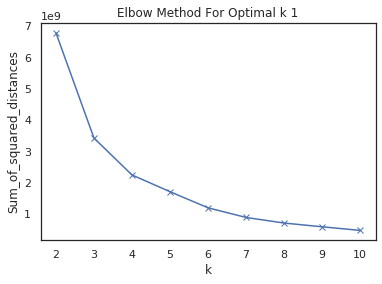

In [0]:
import matplotlib.pyplot as plt
plt.plot(k_1, inert_1, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k 1')
plt.show()

In [0]:
k_2 = []
inert_2 = []
from sklearn.cluster import KMeans, MeanShift
for k in range (2, 11):
 
	# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
  kmeans_model = KMeans(n_clusters=k, random_state=1).fit(good_major_2)
	
	# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
  labels = kmeans_model.labels_
  
 
	# Sum of distances of samples to their closest cluster center
  inertia = kmeans_model.inertia_
  k_2.append(k)
  inert_2.append(inertia)
  print("k:",k, " cost:", inertia)
  print(pd.value_counts(labels))

k: 2  cost: 28900333181.196346
0    32946
1      976
dtype: int64
k: 3  cost: 19928838891.791706
0    23531
2     9835
1      556
dtype: int64
k: 4  cost: 12833188344.246778
2    17243
0     9388
1     6774
3      517
dtype: int64
k: 5  cost: 7251884617.599769
2    16696
0     8970
1     6653
3     1481
4      122
dtype: int64
k: 6  cost: 5369555080.574471
2    16222
0     8827
1     6632
5     1862
3      312
4       67
dtype: int64
k: 7  cost: 4485242475.852481
0    15755
3     8716
2     6619
6     1883
5      711
1      179
4       59
dtype: int64
k: 8  cost: 3690234256.3893204
1    13988
3     8677
6     4260
0     4173
7     1879
4      707
2      179
5       59
dtype: int64
k: 9  cost: 3052706313.5187545
5    13977
1     8673
2     4259
8     4173
0     1879
4      710
6      179
3       59
7       13
dtype: int64
k: 10  cost: 2525252133.996955
3    12918
0     5464
9     4390
6     4254
1     4157
4     1815
7      676
5      176
2       59
8       13
dtype: int64


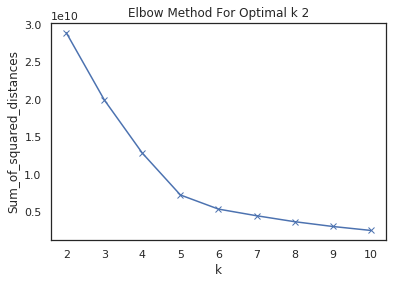

In [0]:
import matplotlib.pyplot as plt
plt.plot(k_2, inert_2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k 2')
plt.show()

In [0]:
k_3 = []
inert_3 = []
from sklearn.cluster import KMeans, MeanShift
for k in range (2, 11):
 
	# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
  kmeans_model = KMeans(n_clusters=k, random_state=1).fit(good_major_3)
	
	# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
  labels = kmeans_model.labels_
	# Sum of distances of samples to their closest cluster center
  inertia = kmeans_model.inertia_
  k_3.append(k)
  inert_3.append(inertia)
  print("k:",k, " cost:", inertia)
  print(pd.value_counts(labels))

k: 2  cost: 6835432900.754336
0    15489
1    11466
dtype: int64
k: 3  cost: 3804092051.1056886
1    11078
2     8978
0     6899
dtype: int64
k: 4  cost: 2714531244.9449415
1    8042
2    7329
0    6297
3    5287
dtype: int64
k: 5  cost: 1867408222.2858717
3    8042
0    7328
1    6297
2    5287
4       1
dtype: int64
k: 6  cost: 1377815262.7553356
1    6597
3    6006
5    5284
0    4809
2    4258
4       1
dtype: int64
k: 7  cost: 1024134418.5346086
1    6618
3    6061
2    5277
4    4769
0    4224
6       5
5       1
dtype: int64
k: 8  cost: 753057473.4712594
3    5746
0    5363
5    4667
2    4307
7    3558
1    3308
6       5
4       1
dtype: int64
k: 9  cost: 598996348.0092773
6    4723
1    4204
3    4187
4    3906
0    3705
2    3160
8    3064
7       5
5       1
dtype: int64
k: 10  cost: 493980141.8494721
8    4257
3    3921
2    3879
0    3561
9    3297
7    2794
1    2622
5    2618
6       5
4       1
dtype: int64


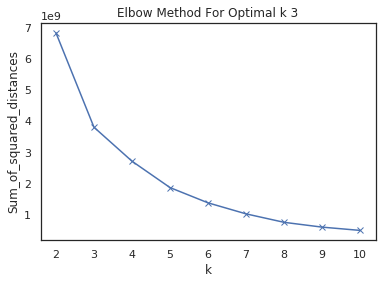

In [0]:
import matplotlib.pyplot as plt
plt.plot(k_3, inert_3, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k 3')
plt.show()

In [0]:
kmean_1 = KMeans(n_clusters=3, random_state=1).fit(good_major_1)
kmean_2 = KMeans(n_clusters=6, random_state=1).fit(good_major_2)
kmean_3 = KMeans(n_clusters=2, random_state=1).fit(good_major_3)

predict_1 = kmean_1.predict(good_major_1)
predict_2 = kmean_2.predict(good_major_2)
predict_3 = kmean_3.predict(good_major_3)

good_major_1["Cluster_label"] = predict_1
good_major_2["Cluster_label"] = predict_2
good_major_3["Cluster_label"] = predict_3

In [0]:
good_major_2["Cluster_label"].value_counts()

2    16222
0     8827
1     6632
5     1862
3      312
4       67
Name: Cluster_label, dtype: int64

In [0]:
good_major_4

,SeriousDlqin2yrs,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,Log.Debt,RevolvingLines,HasRevolvingLines,HasRealEstateLoans,HasMultipleRealEstateLoans,EligibleSS,DTIOver33,DTIOver43,DisposableIncome,RevolvingToRealEstate,NumberOfTime30-59DaysPastDueNotWorseLarge,NumberOfTime30-59DaysPastDueNotWorse96,NumberOfTime30-59DaysPastDueNotWorse98,Never30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorseLarge,NumberOfTime60-89DaysPastDueNotWorse96,NumberOfTime60-89DaysPastDueNotWorse98,Never60-89DaysPastDueNotWorse,NumberOfTimes90DaysLateLarge,NumberOfTimes90DaysLate96,NumberOfTimes90DaysLate98,Never90DaysLate,IncomeDivBy10,IncomeDivBy100,IncomeDivBy1000,IncomeDivBy5000,Weird0999Utilization,FullUtilization,ExcessUtilization,NumberOfTime30-89DaysPastDueNotWorse,Never30-89DaysPastDueNotWorse,NeverPastDue,Log.RevolvingUtilizationTimesLines,Log.RevolvingUtilizationOfUnsecuredLines,DelinquenciesPerLine,MajorDelinquenciesPerLine,MinorDelinquenciesPerLine,DelinquenciesPerRevolvingLine,MajorDelinquenciesPerRevolvingLine,MinorDelinquenciesPerRevolvingLine,Log.DebtPerLine,Log.DebtPerRealEstateLine,Log.DebtPerPerson,RevolvingLinesPerPerson,RealEstateLoansPerPerson,YearsOfAgePerDependent,Log.MonthlyIncome,Log.IncomePerPerson,Log.IncomeAge,Log.NumberOfTimesPastDue,Log.NumberOfTimes90DaysLate,Log.NumberOfTime30-59DaysPastDueNotWorse,Log.NumberOfTime60-89DaysPastDueNotWorse,Log.Ratio90to30-59DaysLate,Log.Ratio90to60-89DaysLate,AnyOpenCreditLinesOrLoans,Log.NumberOfOpenCreditLinesAndLoans,Log.NumberOfOpenCreditLinesAndLoansPerPerson,Has.Dependents,Log.HouseholdSize,Log.DebtRatio,Log.DebtPerDelinquency,Log.DebtPer90DaysLate,Log.UnknownIncomeDebtRatio,Log.UnknownIncomeDebtRatioPerPerson,Log.UnknownIncomeDebtRatioPerLine,Log.UnknownIncomeDebtRatioPerRealEstateLine,Log.UnknownIncomeDebtRatioPerDelinquency,Log.UnknownIncomeDebtRatioPer90DaysLate,Log.NumberRealEstateLoansOrLines,LowAge,Log.age
84280,0,0,0,1,0,0,0,0.0,1,8.405957,12,1,1,1,0,1,0,7849.363035,3.000000,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0.000000,0.000000e+00,0.000,0.0,0.000,0.000000,0.0,0.000000,5.633368,7.019663,8.405957,12.000000,3.000000,42.000000,9.419223,9.419223,5.658023,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,2.708050,2.708050,0,0.000000,-1.013266,8.405957,8.405957,0.0,0.000000,-2.772589,-1.386294,0.000000,0.0,1.098612,0,3.218876
91877,0,0,0,1,0,0,0,0.0,0,7.895714,32,1,1,0,1,0,0,7914.253376,10.666667,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0.194033,-5.006881e+00,0.000,0.0,0.000,0.000000,0.0,0.000000,4.340366,6.797102,7.895714,32.000000,2.000000,61.000000,9.268609,9.268609,5.141475,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,3.526361,3.526361,0,0.000000,-1.372895,7.895714,7.895714,0.0,0.000000,-3.555348,-1.098612,0.000000,0.0,0.693147,0,3.784190
65678,0,0,0,0,0,0,0,0.0,0,4.672742,0,0,0,0,1,0,0,11393.009302,0.000000,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,2,0,0,0.000000,-1.000000e-07,0.000,0.0,0.000,0.000000,0.0,0.000000,4.672742,4.672742,3.979595,0.000000,0.000000,32.000000,9.350102,8.656955,5.175715,0.693147,0.0,0.693147,0.0,-0.693147,0.0,0,0.000000,-0.693147,1,0.693147,-4.677360,3.574130,4.672742,0.0,-0.693147,0.000000,0.000000,-1.098612,0.0,0.000000,0,3.850148
123035,0,0,0,1,0,0,0,0.0,0,6.513135,8,1,1,0,1,0,0,9826.064189,4.000000,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,1,1,2.197224,-1.000000e-07,0.000,0.0,0.000,0.000000,0.0,0.000000,4.210550,5.819988,6.513135,8.000000,1.000000,69.000000,9.259131,9.259131,5.010635,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,2.197225,2.197225,0,0.000000,-2.745996,6.513135,6.513135,0.0,0.000000,-2.302585,-0.693147,0.000000,0.0,0.000000,0,3.951244
27703,0,0,0,0,0,0,0,0.0,0,8.125564,8,1,1,0,0,0,0,11620.225320,4.000000,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,1,1,2.048366,-1.691258e-01,0.000,0.0,0.000,0.000000,0.0,0.000000,5.822979,7.432417,7.432417,4.000000,0.500000,17.000000,9.615805,8.922658,6.060457,0.000000,0.0,0.000000,0.0,0.00000

In [0]:
for i in good_major_2.Cluster_label.unique():
  if good_major_2.Cluster_label[good_major_2.Cluster_label == i].value_counts()[i] < 10000:
    good_major_2.Cluster_label[good_major_2.Cluster_label == i] = 0
good_major_2.Cluster_label.value_counts()

0    17700
2    16222
Name: Cluster_label, dtype: int64

In [0]:
#Phân dữ liệu training thành 9 cụm nhỏ khác nhau
good_1 = good_major_1[good_major_1.Cluster_label == 0].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_2 = good_major_1[good_major_1.Cluster_label == 1].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_3 = good_major_1[good_major_1.Cluster_label == 2].loc[:, "SeriousDlqin2yrs":"Log.age"]

good_4 = good_major_2[good_major_2.Cluster_label == 0].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_5 = good_major_2[good_major_2.Cluster_label == 2].loc[:, "SeriousDlqin2yrs":"Log.age"]

good_6 = good_major_3[good_major_3.Cluster_label == 0].loc[:, "SeriousDlqin2yrs":"Log.age"]
good_7 = good_major_3[good_major_3.Cluster_label == 1].loc[:, "SeriousDlqin2yrs":"Log.age"]

good_8 = good_major_4

good_9 = good_major_5


In [0]:
from sklearn.utils import resample
# bad debt data sample
data = train_bad_debt
# prepare bootstrap sample
bad_1 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_2 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_3 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_4 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_5 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_6 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_7 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_8 = resample(data, replace=True, n_samples=10000, random_state=1)
bad_9 = resample(data, replace=True, n_samples=10000, random_state=1)

# print('Bootstrap Sample: %s' % boot)

In [0]:
# # out of bag observations
# oob = pd.DataFrame(columns = data.columns)
# for i in range(len(data)):
#   a  = data.iloc[i,:]
#   if all in boot.isin(a) == False:
#     oob = oob.append(a)
# # print('OOB Sample: %s' % oob)
# print(type(oob))
# # boot.head()

In [0]:
train_1 = pd.concat([good_1,bad_1], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_2 = pd.concat([good_2,bad_2], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_3 = pd.concat([good_3,bad_3], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_4 = pd.concat([good_4,bad_4], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_5 = pd.concat([good_5,bad_5], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_6 = pd.concat([good_6,bad_6], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_7 = pd.concat([good_7,bad_7], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_8 = pd.concat([good_8,bad_8], ignore_index=True).sample(frac = 1).reset_index(drop = True)
train_9 = pd.concat([good_9,bad_9], ignore_index=True).sample(frac = 1).reset_index(drop = True)

In [0]:
train_9.head()

,SeriousDlqin2yrs,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,Log.Debt,RevolvingLines,HasRevolvingLines,HasRealEstateLoans,HasMultipleRealEstateLoans,EligibleSS,DTIOver33,DTIOver43,DisposableIncome,RevolvingToRealEstate,NumberOfTime30-59DaysPastDueNotWorseLarge,NumberOfTime30-59DaysPastDueNotWorse96,NumberOfTime30-59DaysPastDueNotWorse98,Never30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorseLarge,NumberOfTime60-89DaysPastDueNotWorse96,NumberOfTime60-89DaysPastDueNotWorse98,Never60-89DaysPastDueNotWorse,NumberOfTimes90DaysLateLarge,NumberOfTimes90DaysLate96,NumberOfTimes90DaysLate98,Never90DaysLate,IncomeDivBy10,IncomeDivBy100,IncomeDivBy1000,IncomeDivBy5000,Weird0999Utilization,FullUtilization,ExcessUtilization,NumberOfTime30-89DaysPastDueNotWorse,Never30-89DaysPastDueNotWorse,NeverPastDue,Log.RevolvingUtilizationTimesLines,Log.RevolvingUtilizationOfUnsecuredLines,DelinquenciesPerLine,MajorDelinquenciesPerLine,MinorDelinquenciesPerLine,DelinquenciesPerRevolvingLine,MajorDelinquenciesPerRevolvingLine,MinorDelinquenciesPerRevolvingLine,Log.DebtPerLine,Log.DebtPerRealEstateLine,Log.DebtPerPerson,RevolvingLinesPerPerson,RealEstateLoansPerPerson,YearsOfAgePerDependent,Log.MonthlyIncome,Log.IncomePerPerson,Log.IncomeAge,Log.NumberOfTimesPastDue,Log.NumberOfTimes90DaysLate,Log.NumberOfTime30-59DaysPastDueNotWorse,Log.NumberOfTime60-89DaysPastDueNotWorse,Log.Ratio90to30-59DaysLate,Log.Ratio90to60-89DaysLate,AnyOpenCreditLinesOrLoans,Log.NumberOfOpenCreditLinesAndLoans,Log.NumberOfOpenCreditLinesAndLoansPerPerson,Has.Dependents,Log.HouseholdSize,Log.DebtRatio,Log.DebtPerDelinquency,Log.DebtPer90DaysLate,Log.UnknownIncomeDebtRatio,Log.UnknownIncomeDebtRatioPerPerson,Log.UnknownIncomeDebtRatioPerLine,Log.UnknownIncomeDebtRatioPerRealEstateLine,Log.UnknownIncomeDebtRatioPerDelinquency,Log.UnknownIncomeDebtRatioPer90DaysLate,Log.NumberRealEstateLoansOrLines,LowAge,Log.age
0,0,0,1,1,0,0,2264,0.0,0,0.000000,9,1,1,0,0,0,0,0.000000,3.000000,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,1,1,0.557262,-2.490407,0.000000,0.0,0.000000,0.000000,0.0,0.000000,-2.484907,-1.098612,0.000000,9.0,2.0,35.0,0.000000,0.000000,-3.583519,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,2.397895,2.397895,0,0.000000,0.000000,0.000000,0.000000,7.724888,7.724888,5.239982,6.626276,7.724888,7.724888,0.693147,0,2.890372
1,0,0,0,0,0,0,0,0.0,0,8.850910,4,1,1,1,0,0,0,19519.263417,1.000000,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0.860197,-1.076147,0.000000,0.0,0.000000,0.000000,0.0,0.000000,6.771468,7.464615,8.157763,2.0,1.5,23.0,10.184900,9.491753,6.334752,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.945910,1.252763,1,0.693147,-1.333990,8.850910,8.850910,0.000000,-0.693147,-2.079442,-1.386294,0.000000,0.000000,1.098612,0,3.367296
2,1,0,0,0,0,0,0,0.0,0,7.182930,12,1,0,0,0,0,0,4183.239412,12.000000,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,2.511692,-0.057827,0.083333,0.0,0.083333,0.083333,0.0,0.083333,4.617981,7.182930,6.489783,6.0,0.0,20.5,8.612503,7.919356,4.874834,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,2.484907,1.791759,1,0.693147,-1.429573,6.489783,7.182930,0.000000,-0.693147,-2.564949,0.000000,-0.693147,0.000000,0.000000,0,3.178054
3,1,0,0,1,0,0,0,0.0,0,8.254434,12,1,1,0,0,1,0,6655.366158,6.000000,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,2,0,0,1.381272,-1.392997,0.153846,0.0,0.153846,0.166667,0.0,0.166667,5.615376,7.561286,8.254434,12.0,1.0,51.0,9.259131,9.259131,5.307887,0.693147,0.0,0.693147,0.0,-0.693147,0.0,1,2.564949,2.564949,0,0.000000,-1.004697,7.155821,8.254434,0.000000,0.000000,-2.639057,-0.693147,-1.098612,0.000000,0.000000,0,3.526361
4,0,0,0,0,0,0,0,0.0,0,8.829195,7,1,1,0,1,0,0,24969.214801,2.333333,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0.066719,-4.619635,0.000000,0.0,0.000000,0.000000,0.0,0.000000,6.526610,7.730583,8.136048,3.5,1.0,31.5,10.367222,9.674074,6.208338,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,2.197225,1.504077,1,0.693147,-1.53

In [0]:
x_train_1, y_train_1 = train_1.loc[:, train_1.columns != "SeriousDlqin2yrs"], train_1["SeriousDlqin2yrs"]
x_train_2, y_train_2 = train_2.loc[:, train_2.columns != "SeriousDlqin2yrs"], train_2["SeriousDlqin2yrs"]
x_train_3, y_train_3 = train_3.loc[:, train_3.columns != "SeriousDlqin2yrs"], train_3["SeriousDlqin2yrs"]
x_train_4, y_train_4 = train_4.loc[:, train_4.columns != "SeriousDlqin2yrs"], train_4["SeriousDlqin2yrs"]
x_train_5, y_train_5 = train_5.loc[:, train_5.columns != "SeriousDlqin2yrs"], train_5["SeriousDlqin2yrs"]
x_train_6, y_train_6 = train_6.loc[:, train_6.columns != "SeriousDlqin2yrs"], train_6["SeriousDlqin2yrs"]
x_train_7, y_train_7 = train_7.loc[:, train_7.columns != "SeriousDlqin2yrs"], train_7["SeriousDlqin2yrs"]
x_train_8, y_train_8 = train_8.loc[:, train_8.columns != "SeriousDlqin2yrs"], train_8["SeriousDlqin2yrs"]
x_train_9, y_train_9 = train_9.loc[:, train_9.columns != "SeriousDlqin2yrs"], train_9["SeriousDlqin2yrs"]


In [0]:
llre_1 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_2 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_3 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_4 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_5 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_6 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_7 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_8 = LogisticRegression(penalty  = "l1", class_weight = None)
llre_9 = LogisticRegression(penalty  = "l1", class_weight = None)


In [0]:
llre_1.fit(x_train_1,y_train_1)
llre_2.fit(x_train_2,y_train_2)
llre_3.fit(x_train_3,y_train_3)
llre_4.fit(x_train_4,y_train_4)
llre_5.fit(x_train_5,y_train_5)
llre_6.fit(x_train_6,y_train_6)
llre_7.fit(x_train_7,y_train_7)
llre_8.fit(x_train_8,y_train_8)
llre_9.fit(x_train_9,y_train_9)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Sử dụng các mô hình nhỏ để dự đoán

#Dùng mô hình để dự đoán lại y train
y_train_pred_1 = llre_1.predict(x_train_1)
y_train_pred_2 = llre_2.predict(x_train_2)
y_train_pred_3 = llre_3.predict(x_train_3)
y_train_pred_4 = llre_4.predict(x_train_4)
y_train_pred_5 = llre_5.predict(x_train_5)
y_train_pred_6 = llre_6.predict(x_train_6)
y_train_pred_7 = llre_7.predict(x_train_7)
y_train_pred_8 = llre_8.predict(x_train_8)
y_train_pred_9 = llre_9.predict(x_train_9)

#Dùng mô hình để dự đoán y test

y_llre_1 = llre_1.predict(x_test)
y_llre_2 = llre_2.predict(x_test)
y_llre_3 = llre_3.predict(x_test)
y_llre_4 = llre_4.predict(x_test)
y_llre_5 = llre_5.predict(x_test)
y_llre_6 = llre_6.predict(x_test)
y_llre_7 = llre_7.predict(x_test)
y_llre_8 = llre_8.predict(x_test)
y_llre_9 = llre_9.predict(x_test)

In [0]:
mse_1 = MSE(y_test, y_llre_1)
mse_2 = MSE(y_test, y_llre_2)
mse_3 = MSE(y_test, y_llre_3)
mse_4 = MSE(y_test, y_llre_4)
mse_5 = MSE(y_test, y_llre_5)
mse_6 = MSE(y_test, y_llre_6)
mse_7 = MSE(y_test, y_llre_7)
mse_8 = MSE(y_test, y_llre_8)
mse_9 = MSE(y_test, y_llre_9)

In [0]:
print(mse_1)
print(mse_2)
print(mse_3)
print(mse_4)
print(mse_5)
print(mse_6)
print(mse_7)
print(mse_8)
print(mse_9)


0.3248
0.3237333333333333
0.45066666666666666
0.6194
0.7102666666666667
0.36966666666666664
0.4892666666666667
0.6162666666666666
0.7060666666666666


In [0]:
auc_train_1 = roc_auc_score(y_train_1, y_train_pred_1)
auc_train_2 = roc_auc_score(y_train_2, y_train_pred_2)
auc_train_3 = roc_auc_score(y_train_3, y_train_pred_3)
auc_train_4 = roc_auc_score(y_train_4, y_train_pred_4)
auc_train_5 = roc_auc_score(y_train_5, y_train_pred_5)
auc_train_6 = roc_auc_score(y_train_6, y_train_pred_6)
auc_train_7 = roc_auc_score(y_train_7, y_train_pred_7)
auc_train_8 = roc_auc_score(y_train_8, y_train_pred_8)
auc_train_9 = roc_auc_score(y_train_9, y_train_pred_9)

In [0]:
print(auc_train_1)
print(auc_train_2)
print(auc_train_3)
print(auc_train_4)
print(auc_train_5)
print(auc_train_6)
print(auc_train_7)
print(auc_train_8)
print(auc_train_9)

0.7895214285714287
0.8019455887993864
0.8060078947368421
0.8681183615819209
0.896174990753298
0.8330009135515527
0.8842048927263213
0.9376556925996204
0.952812706480305


In [0]:
auc_test_1 = roc_auc_score(y_test, y_llre_1)
auc_test_2 = roc_auc_score(y_test, y_llre_2)
auc_test_3 = roc_auc_score(y_test, y_llre_3)
auc_test_4 = roc_auc_score(y_test, y_llre_4)
auc_test_5 = roc_auc_score(y_test, y_llre_5)
auc_test_6 = roc_auc_score(y_test, y_llre_6)
auc_test_7 = roc_auc_score(y_test, y_llre_7)
auc_test_8 = roc_auc_score(y_test, y_llre_8)
auc_test_9 = roc_auc_score(y_test, y_llre_9)

In [0]:
print(auc_test_1)
print(auc_test_2)
print(auc_test_3)
print(auc_test_4)
print(auc_test_5)
print(auc_test_6)
print(auc_test_7)
print(auc_test_8)
print(auc_test_9)


0.6843512471800859
0.6969551444259776
0.6280150047820388
0.5639813787187412
0.5375059361459809
0.6880773340477246
0.6670309497313589
0.6309126489218491
0.5832579777278866


In [0]:
f1_1 = f1_score(y_test, y_llre_1)
f1_2 = f1_score(y_test, y_llre_2)
f1_3 = f1_score(y_test, y_llre_3)
f1_4 = f1_score(y_test, y_llre_4)
f1_5 = f1_score(y_test, y_llre_5)
f1_6 = f1_score(y_test, y_llre_6)
f1_7 = f1_score(y_test, y_llre_7)
f1_8 = f1_score(y_test, y_llre_8)
f1_9 = f1_score(y_test, y_llre_9)

In [0]:
print(f1_1)
print(f1_2)
print(f1_3)
print(f1_4)
print(f1_5)
print(f1_6)
print(f1_7)
print(f1_8)
print(f1_9)

0.2224704755825088
0.2294509679466836
0.1758107778590588
0.14344980178851297
0.13424345847554037
0.21447797138404873
0.18807390198030755
0.16585453889189677
0.14801705413884642


In [0]:
import statistics
y_llre_total = np.concatenate((y_llre_1, y_llre_2, y_llre_3, y_llre_4, y_llre_5 ,y_llre_6, y_llre_7, y_llre_8, y_llre_9)).reshape(9, -1)
y_llre_total = y_llre_total.T
llre = []
for i in range(y_llre_total.shape[0]):
  f = statistics.mode(y_llre_total[i])
  llre.append(f)
llre = np.array(llre)

In [0]:
print(MSE(y_test, llre))
print(f1_score(y_test, llre))
print(roc_auc_score(y_test, llre))

0.40886666666666666
0.2126075234304789
0.6999303938580771


In [0]:
#new meta classifier 
meta_clf = LogisticRegression(penalty = "l1")
